# Tutorial on automatic CNN optimization for spectral analysis: classification case <font color='red'>v2.1</font>

**This notebook is a complementary file of D. Passos and P. Mishra, "A tutorial on automatic hyperparameter tuning of deep spectral modelling for regression and classification tasks ", Chemometrics and Intelligent Laboratory Systems, 2022 (in review). It exemplifies how to optimize the hyperparameters and architecture of a DL Convolutional Neural Network (CNN) model implemented in Tensorflow 2.5 to predict 30 classes wheat kernels based on their Vis-NIR spectra.**

The data set used in this tutorial consists of multi-class wheat spectra presented originally by *L. Zhou, C. Zhang, M.F. Taha, X. Wei, Y. He, Z. Qiu, Y. Liu, Wheat Kernel Variety Identification Based on a Large Near-Infrared Spectral Dataset and a Novel Deep Learning-Based Feature Selection Method, Frontiers in Plant Science, 11 (2020) 1682.*
<url>https://www.frontiersin.org/articles/10.3389/fpls.2020.575810/full</url>.

The implementation of the Bayesian Optimization pipeline is the same used in *D. Passos, P. Mishra, An automated deep learning pipeline based on advanced optimisations for leveraging spectral classification modelling”, Chemometrics and Intelligent Laboratory Systems 215, (2021), 104354,* <url>https://doi.org/10.1016/j.chemolab.2021.104354</url>. It combines Bayesian Optimization (using TPE) and Hyperband algorithms (implemented in the Optuna library) for for optimization of the CNN model. This optimization is done by exploring a low level Neural Architecture Search (NAS) and hyperparameters optimization in parallel. The optimization of the model's Learning Rate is done separately using a LR range test. This is done to exemplify a wider breadth of optimization techniques. 

This tutorial also features a custom implementation of the grad-CAM method that can help in terms of for CNN interpretability, i.e., what wavelengths in the spectra influenced the classification of the samples. 

<br>
<br>
<font color='red'>
Version 1 of this tutorial (see original paper and notebok) was created using following main packages versions:<br>
Tensorflow  2.5.0 <br>
Tensorflow add-ons  0.13.0 <br>
tqdm  4.46.0 <br>
Numpy  1.19.5 <br>
Pandas 1.1.0 <br>
Optuna  2.9.1 
<br>    
<br>    
<b>This version was modified in order to be compatible with updated versions of the packages and python 3.10.</b>
Tensorflow  2.9.1 <br>
Tensorflow add-ons  0.19.0<br>
tqdm 4.64.1<br>
Numpy  1.24.<br>
Pandas 1.5.2<br>
Optuna  3.0.5<br>
Scikit-Learn  1.2.0<br>
<br>
<b>NOTE: Due to the different Tensorflow version (and the associated NVIDIA CUDADNN drivers, results may result slightly in some computations).</b>
The main differences from the original notebook are highlighted in red text in the markdown cells.
</font> 

Newer versions of these packages should be compatible but a waring must be issued. 


The tutorial is divided into 7 sections:<br>
1. **Import libraries:** Import external python libraries, e.g. numpy, pandas, etc.
2. **Help functions**: functions created to aid the analysis, plots, etc. Run each cell once.
3. **Data wrangling**: load the data, perform pre-processing operations, etc...
    <br>3.1 Visualization of the input data
    <br>3.2 Partition the data and rescale it
4. **Optimizing the Learning Rate using a LR range test**
    <br>4.1 Define the base CNN architecture
    <br>4.2 Apply LR Range test to the base CNN
    <br>4.3 Compute the base model performance
5. **Optimization of the model hyperparameters**: The optimization is done using the Optuna package
    <br>5.1 Define the CNN model
    <br>5.2 Optimize the model hyperparameters
6. **Post-optimization analysis and final model predictions**
    <br>6.1 Making predictions with the optimized model
   <br>6.2 Extra visualizations of the optimization process
7. **GradCAM implementation**
    <br>7.1 Compute GRAD-CAM on the different spectra per class

*<font color='red'>Notebook version: 2.1 (updated in May 2023)</font>*


### BUG UPDATE!!
<font color='red'>**I detected a typo in the function <code>create_model()</code> defined in section 5.1). The range for the number of DENSE layers starts at index=1 (it should start at index=0). The loop for the hyperparameter optimization (HPO) generated NUM_FC_UNITS and DROPOUT_RATE lists that start at index=0. This means that the HP in these lists that have index=0 were never considered by the CNN during the optimization because only indices>0 are used. In practice this means that when we instantiate a new model, i.e. <code>create_model(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta)</code> with <code>(5, [360,350,132,442,334], 3, [0.555,0.165,0.13,0.46,0.085], 1e-05)</code> the first values for lists num_FC_units (i.e. 360) and DROPOUT (i.e. 0.555) are not considered by the model. We can confirm this in section 6.1. If we change the first items on these lists when we define "model454" the prediction results is exactly the same, i.e. the CNN is not using those hyperparameters because the corresponding DENSE_0/DROPOUT_0 layer pair was never created in the first place.**</font>

<font color='red'>**In terms of practical effects this means that the reported model complexity is higher than the real model. Our conclusion that the optimized model <code>model454 = create_model(5, [360,350,132,442,334], 3, [0.555,0.165,0.13,0.46,0.085], 1e-05)</code> had 5 optimized DENSE/DROPOUT layers means that in fact it had 4 optimized DENSE/DROPOUT layers with [350,132,442,334] / [0.165,0.13,0.46,0.085] respectively. That being said, the optimization pipeline suggested here remains valid and a useful way of dealing with CNN HPO for spectral analysis. This notebook will remain as is for the mean time for warning purposes and will be completely substituted with a corrected version after some time, after dealing with the correction of the online accompanying paper. Do a local search for #BUG keyword/comments in the present code to know where things will change**</font>

## 1) Import libraries
<font color='red'>v2 - Ipython display and HTML import path updated</font>

In [2]:
## Trick to teadjust cell width in Jupyter / browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Import external libraries
import os
import sys
from sys import stdout
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
import seaborn as sns 
import pandas as pd
import logging
import tqdm

import scipy.io as sio
from scipy.signal import savgol_filter, general_gaussian

from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical  

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF
import optuna

C:\Users\dario\miniconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
## Check for version of installed packages in the system
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('tqdm ', tqdm.__version__)
print('Numpy ', np.__version__)
print('Pandas', pd.__version__)
print('Optuna ', optuna.__version__)
# print('livelossplot ', livelossplot.__version__)

Tensorflow  2.9.1
Tensorflow add-ons  0.19.0
tqdm  4.64.1
Numpy  1.24.1
Pandas 1.5.2
Optuna  3.0.5


## 2) Help functions
In this section we implement a series of help functions that will be used in this notebook. Run every cell once to ensure that all help functions are loaded.

Function that sets python's and TF random variable's seed to a specified value. This is important if one wants to be able to produce reproducible results. 

<div class="alert alert-block alert-warning">
    That being said, obtaining completely reproducible results when running these models on a GPU might not be possible. The Keras documentation notes that when running code on a GPU, some operations have non-deterministic outputs due to the fact that GPUs run many operations (summations) in parallel, and so the order of execution from run to run is not always the same. These operation involve floating-point with finite precision, and because of that certain GPU operations, such as convolutions, can yields slightly different results. A very small rounding error of 1e-14 in one operation can be negligible, but when this operation is done many thousands of times, this "imprecision error" at each level of the neural network (and for each batch), accumulates over layers and over time, eventually making model weights diverge significantly from run to run. If the user really needs fully deterministic computations, it might have to run the DL model on a CPU or applied specialized patches such as those proposed in the <a href="https://github.com/NVIDIA/framework-determinism">GPU-Determinism GitHub repo</a>
</div>

In [3]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
reproducible_comp()

Define a help function to compute the Standard Normal Variate correction to the spectra

In [4]:
def snv(input_data):
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return output_data

Define functions to standardize the data in columns

In [5]:
## Define a couple of help functions
## Function to standardize a data set column-wise

def standardize_column(X_train, X_calib, X_test):
    ## We train the scaler on the train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_calib_scaled = scaler.transform(X_calib)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_calib_scaled, X_test_scaled]

Custom function to compute grad-CAM scores

In [6]:
## Adapted for 1d input data from https://keras.io/examples/vision/grad_cam/
    
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    ## over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(1))

    ## We multiply each channel in the feature map array
    ## by "how important this channel is" with regard to the top predicted class
    ## then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose, we will also normalize the heatmap between 0 & 1
    #   heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()    

Customized linecolor function for grad-CAM heatmap production

In [7]:
## Code adapted from: https://github.com/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

## Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
## The color is taken from optional data in z, and creates a LineCollection.

## z can be:
## - empty, in which case a default coloring will be used based on the position along the input arrays
## - a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
## - an array of the length of at least the same length as x, to color according to this data
## - an array of a smaller length, in which case the colors are repeated along the curve

## The function colorline returns the LineCollection created, which can be modified afterwards.


## Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


## Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('jet'), norm=colors.Normalize(vmin=0.0, vmax=1), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
#     plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

Defining functions to be used in the Learning Rate range test

In [8]:
## Source: 
#  https://www.kaggle.com/avanwyk/tf2-super-convergence-with-the-1cycle-policy
#  https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

## Functions to implement the LR scheduler using OneCycleScheduler

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')
        
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses, lw=2)    

Set parameters for graphics formating

In [10]:
## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3) Data wrangling
In this section we load the data set, pre-process it and perform data augmentation in the variable space. Since the data is in .csv format we use Pandas read_csv() function to load all data into a DataFrame object

In [11]:
## Read the data
## calibration
cal1 = pd.read_csv('datasets/DT_train-1.csv',header=None)
cal2 = pd.read_csv('datasets/DT_train-2.csv',header=None)
cal3 = pd.read_csv('datasets/DT_train-3.csv',header=None)
cal4 = pd.read_csv('datasets/DT_train-4.csv',header=None)
cal5 = pd.read_csv('datasets/DT_train-5.csv',header=None)
## validation
val1 = pd.read_csv('datasets/DT_val-1.csv',header=None)
val2 = pd.read_csv('datasets/DT_val-2.csv',header=None)
## test
pre1 = pd.read_csv('datasets/DT_test-1.csv',header=None)
pre2 = pd.read_csv('datasets/DT_test-2.csv',header=None)
pre3 = pd.read_csv('datasets/DT_test-3.csv',header=None)

Concatenate the original data files into calibration/validation and test data sets 

+ `cal_features` -> the **calibration** spectra used for training the model
+ `val_features` -> the **validation** spectra used to perform hyperparameter tuning. Also called **tuning set**
+ `pre_features` -> the **test** spectra on which the optimized model will be "tested" to measure the final molde performance

the `cal_labels`, `val_labels` and `pre_labels` variables contain the corresponding label.

In this step we perform what we call data augmentation in the "feature-space" by concatenating several types of preprocessed spectra. This can be seen by some as a form of feature engineering. This method was presented in *P. Mishra, D. Passos, "A synergistic use of chemometrics and deep learning improved the predictive performance of near-infrared spectroscopy models for dry matter prediction in mango fruit", Chemometrics and Intelligent Laboratory Systems, (2021a) 104287.* <url>https://doi.org/10.1016/j.chemolab.2021.104287</url>, and was shown to be advantageous for spectral analysis. In very broad strokes by using all the main preprocessed types of spectra as a single input, we are offsetting the choice of the best preprocessed data (or parts of it) to the DL algorithm. 

In [12]:
## Concatenate input variables, X
cal_features = np.concatenate((cal1.iloc[:, 0:-1],cal2.iloc[:, 0:-1],cal3.iloc[:, 0:-1],cal4.iloc[:, 0:-1],cal5.iloc[:, 0:-1]),axis=0)
val_features = np.concatenate((val1.iloc[:, 0:-1],val2.iloc[:, 0:-1]),axis = 0)
pre_features = np.concatenate((pre1.iloc[:, 0:-1],pre2.iloc[:, 0:-1],pre3.iloc[:, 0:-1]),axis = 0)

## Concatenate the target variable or lables, Y
cal_labels = np.concatenate((cal1.iloc[:, -1],cal2.iloc[:, -1],cal3.iloc[:, -1],cal4.iloc[:, -1],cal5.iloc[:, -1]),axis = 0)
val_labels = np.concatenate((val1.iloc[:, -1],val2.iloc[:, -1]),axis=0)
pre_labels = np.concatenate((pre1.iloc[:, -1],pre2.iloc[:, -1],pre3.iloc[:, -1]),axis = 0)

## Settings for the smooth derivatives using a Savitsky-Golay filter
w = 13 ## Sav.Gol window size
p = 2  ## Sav.Gol polynomial degree

## Perform data augmentation in the feature space by combining different types of typical chemometric spectral pre-processings
## [spectra, SNV, 1st Deriv., 2nd Deriv., 1st Deriv. SNV, 2nd Deriv. SNV]
cal_features1 = np.concatenate((cal_features, snv(cal_features),savgol_filter(cal_features, w, polyorder = p, deriv=1),\
                                savgol_filter(cal_features, w, polyorder = p, deriv=2),savgol_filter(snv(cal_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(cal_features), w, polyorder = p, deriv=2)),axis = 1)
val_features1 = np.concatenate((val_features, snv(val_features),savgol_filter(val_features, w, polyorder = p, deriv=1),\
                                savgol_filter(val_features, w, polyorder = p, deriv=2),savgol_filter(snv(val_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(val_features), w, polyorder = p, deriv=2)),axis =1)
pre_features1 = np.concatenate((pre_features, snv(pre_features),savgol_filter(pre_features, w, polyorder = p, deriv=1),\
                                savgol_filter(pre_features, w, polyorder = p, deriv=2),savgol_filter(snv(pre_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(pre_features), w, polyorder = p, deriv=2)),axis =1)

The 30 classes of wheat have are defined as integers from 0 to 29 (labels). These classes correspond to specific nomenclature that can be consulted in the original work where the data set was first presented.

### 3.1) Visualization of the input data
Here we provide a couple of visualization methods to plot the input spectra

Plot the first 100 spectra just to check the shape of the data

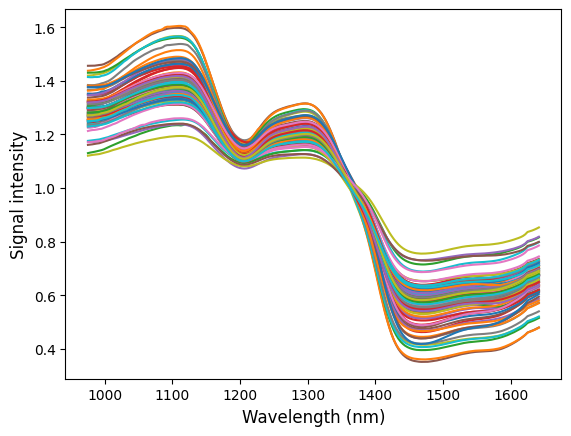

In [13]:
## Create wavelength x-scale by interpolating the range mentioned in the original wheat paper
delta_co = (1645-975)/200 # wavelenght step
# print(delta_co)
co=975+np.arange(200)*delta_co

plt.plot(co, cal_features[:100,:].T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity')
plt.show()

Create a version of the ensemble/concatenated pre-processed validation spectra where each individual pre-processing is normalized between 0 and 1. This will be latter on used with GRAD-Cam for visualization purposes.

In [14]:
## Set the scaler
scaler=MinMaxScaler()

## Create the indiviaually scaled spectra. The scalling is done in the rows, hence we have to transpose the data being transposed.
## After the scalling is applied we transpose the data back to its original form.
test_spectra = np.concatenate(
    (
     scaler.fit_transform(pre_features.T).T, 
     scaler.fit_transform(snv(pre_features).T).T,
     scaler.fit_transform(savgol_filter(pre_features, w, polyorder = p, deriv=1).T).T,
     scaler.fit_transform(savgol_filter(pre_features, w, polyorder = p, deriv=2).T).T,
     scaler.fit_transform(savgol_filter(snv(pre_features), w, polyorder = p, deriv=1).T).T,
     scaler.fit_transform(savgol_filter(snv(pre_features), w, polyorder = p, deriv=2).T).T
    ), axis =1)

Plot a few samples of the augmented input data with the separation between the different pre-processings.

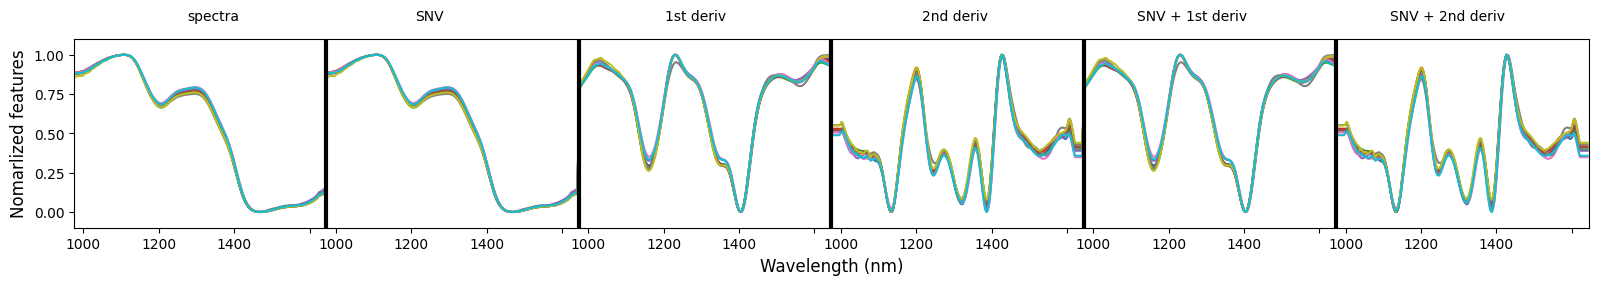

In [15]:
## Plot a couple just for visual check

## Create list with the wavelengths to add to the x-axis labels
single_xscale_labels=[ '1000', '1200', '1400', ' ']
long_xscale_labels=single_xscale_labels + single_xscale_labels + single_xscale_labels \
                 + single_xscale_labels + single_xscale_labels + single_xscale_labels

## Map default x coordinates to required x coordinates/labels for the first pre-processing spec
## First label at 1000-975 = 25, and repeat every 200 pts (the dim. of 1 individ. spectrum)
single_xscale_pos = np.array([25,225,425,625])
## Repeat for the 6 preprocessings (raw included)
long_xscale_pos = np.concatenate([
                      single_xscale_pos , \
                      single_xscale_pos + 670 ,  \
                      single_xscale_pos + 2*670 ,  \
                      single_xscale_pos + 3*670 ,  \
                      single_xscale_pos + 4*670 , \
                      single_xscale_pos + 5*670
                    ])

## Plot
plt.figure(figsize=(16,3))
plt.plot(np.arange(0,4020,3.35),test_spectra[:10,:].T)

## set custom x-labels
plt.xticks(long_xscale_pos, labels=long_xscale_labels, rotation=0)
plt.vlines(np.arange(670,4020,670), ymin=-0.1, ymax=1.1, color='k',lw=3)
plt.ylabel('Nomarlized features')
plt.xlabel('Wavelength (nm)')
plt.ylim(-0.1,1.1)
plt.xlim(0,4020)
plt.annotate('spectra',(0.075,1.1), xycoords='axes fraction')
plt.annotate('SNV',(0.075*3,1.1), xycoords='axes fraction')
plt.annotate('1st deriv',(0.078*5,1.1), xycoords='axes fraction')
plt.annotate('2nd deriv',(0.08*7,1.1), xycoords='axes fraction')
plt.annotate('SNV + 1st deriv',(0.078*9,1.1), xycoords='axes fraction')
plt.annotate('SNV + 2nd deriv',(0.079*11,1.1), xycoords='axes fraction')
plt.tight_layout()
plt.show()

Next, we pick the first spectra from 5 different wheat classes, e.g. [2, 5, 10, 14, 19] and make a subset to use latter in GRAD-Cam

In [15]:
## get indices from the test set for the first spectra of each selected class
print(np.argwhere(pre_labels==2)[0])
print(np.argwhere(pre_labels==5)[0])
print(np.argwhere(pre_labels==10)[0])
print(np.argwhere(pre_labels==14)[0])
print(np.argwhere(pre_labels==19)[0])

[2485]
[6411]
[13117]
[18087]
[24678]


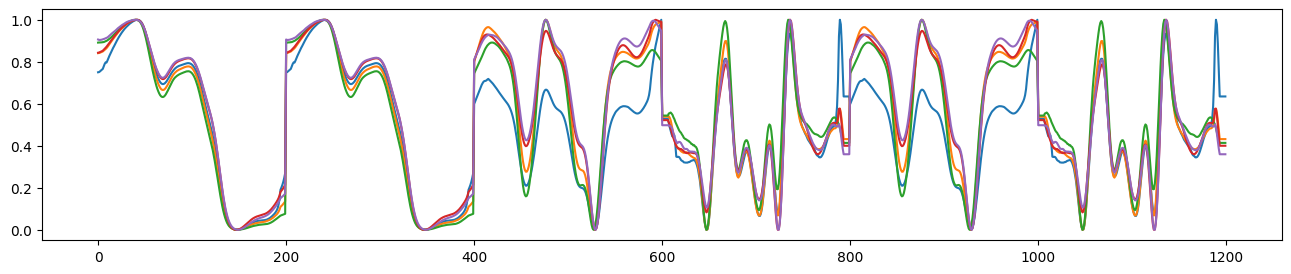

In [16]:
## Given the retrieved indices of the chosen samples we define a small subset of sepctra
samples_SpecClass = test_spectra[[2485,6411,13117,18087,24678],:]
samples_Labels = np.array([2,5,10,14,19], dtype=int)

## visual check
plt.figure(figsize=(16,3))
ax = plt.subplot()
plt.plot(samples_SpecClass.T)
plt.show()

Another way of visualizing the data is to stack the mean spectrum for each class. <br>
Using the test set, we compute the mean spectrum per class and stack them in a single plot

In [17]:
## Select spectra index according to class and compute their mean spectra
list_mean_SpecClass = []
list_mean_labels = []
for i in np.unique(val_labels):
    espec_medio = np.mean(test_spectra[np.argwhere(pre_labels==i).flatten()].T, axis=1)
    label_media = np.mean(pre_labels[np.argwhere(pre_labels==i).flatten()])
    list_mean_SpecClass.append(espec_medio)
    list_mean_labels.append(label_media)

mean_SpecClass=np.array(list_mean_SpecClass)
mean_labels = np.array(list_mean_labels, dtype=int) ## sanity check  - mean lables should be integers otherwise some index in the means might be wrong...

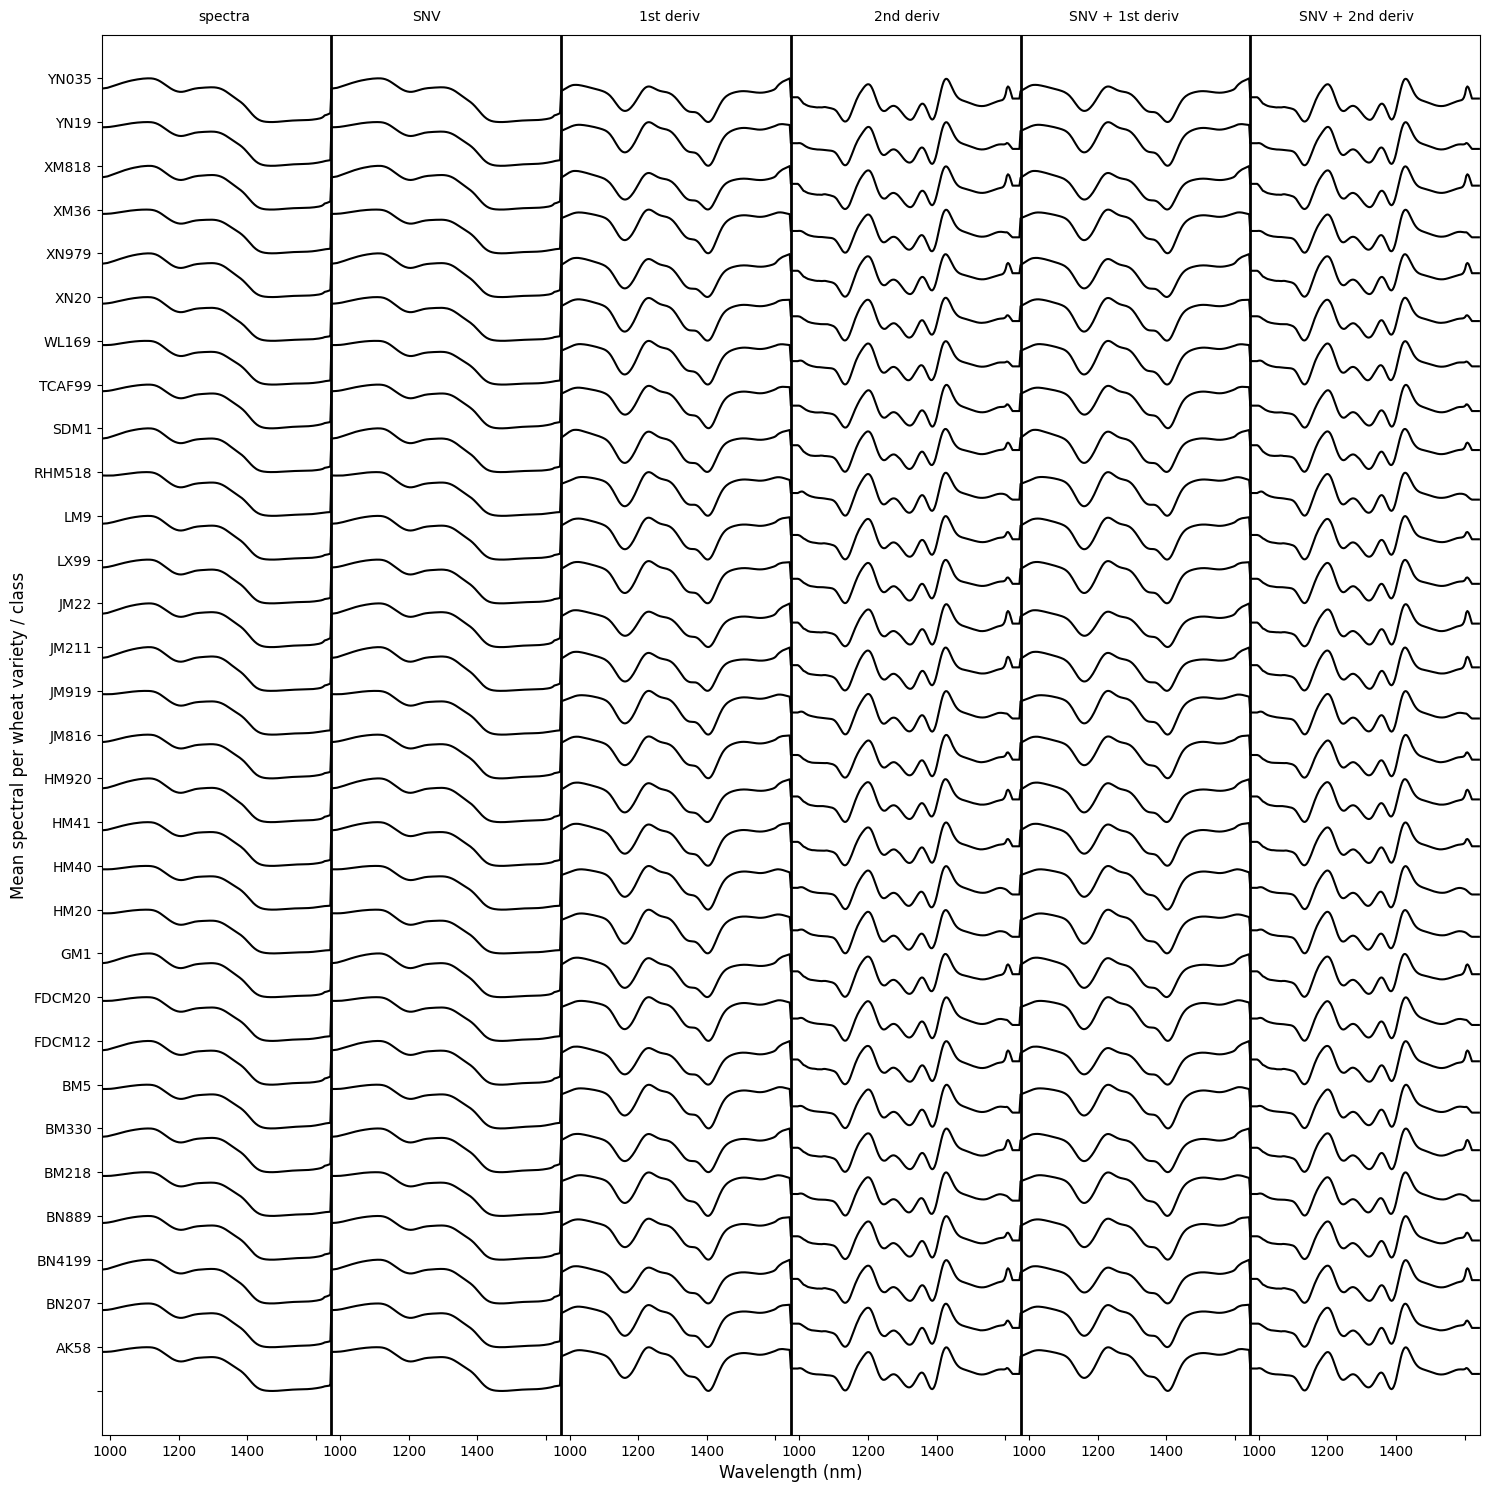

In [18]:
plt.figure(figsize=(15,15)) # plt.plot(val_spectra[np.argwhere(val_labels==0).flatten()].T, 'lightgray')
for i in np.arange(30):
    plt.plot(np.arange(0,4020,3.35),mean_SpecClass[i,:]+i, 'k')

## Trick: Each normalized mean sepctra starts around Y=1, therefore we shift the Y labels by 1 to better correspont the name to the curve
wheat_variaties=[' ','AK58', 'BN207', 'BN4199','BN889', 'BM218', 'BM330', 'BM5', 'FDCM12', 'FDCM20', 'GM1', 'HM20', \
                 'HM40', 'HM41', 'HM920', 'JM816', 'JM919', 'JM211', 'JM22', 'LX99', 'LM9', 'RHM518', 'SDM1', \
                 'TCAF99', 'WL169', 'XN20', 'XN979', 'XM36', 'XM818', 'YN19', 'YN035']    
## set custom x-labels
plt.xticks(long_xscale_pos, labels=long_xscale_labels, rotation=0)
plt.yticks(np.arange(31), labels=wheat_variaties, rotation=0)
plt.vlines(np.arange(670,4020,670), ymin=-1, ymax=33, color='k',lw=2)
plt.ylabel('Mean spectral per wheat variety / class')
plt.xlabel('Wavelength (nm)')
plt.ylim(-1,31)
plt.xlim(0,4020)
plt.annotate('spectra',(0.070,1.01), xycoords='axes fraction')
plt.annotate('SNV',(0.075*3,1.01), xycoords='axes fraction')
plt.annotate('1st deriv',(0.078*5,1.01), xycoords='axes fraction')
plt.annotate('2nd deriv',(0.08*7,1.01), xycoords='axes fraction')
plt.annotate('SNV + 1st deriv',(0.078*9,1.01), xycoords='axes fraction')
plt.annotate('SNV + 2nd deriv',(0.079*11,1.01), xycoords='axes fraction')
plt.tight_layout()
plt.show()

### 3.2)  Partition the data and rescale it

Standardize the input spectra column-wise. This is the data that will be fed into the CNN

In [19]:
## Standardize on columns
x_cal_scaled_col, x_tuning_scaled_col, x_test_scaled_col = standardize_column(cal_features1, val_features1, pre_features1)

## Standardize also the subset of spectra that will be used in grad-CAM (last section of the notebook)
samples_SpecClass_scaled_col = x_test_scaled_col[[2485,6411,13117,18087,24678],:]

Convert labels classes to one-hot format (e.g. 0 -> [1,0,0,0,0,0,...], 1 -> [0,1,0,0,0,0,0,...])

In [20]:
y_cal = to_categorical(cal_labels, num_classes=30)
y_tuning = to_categorical(val_labels, num_classes=30)
y_test = to_categorical(pre_labels, num_classes=30)

# mean_labels_hot = to_categorical(mean_labels, num_classes=30)
samples_Labels_hot = to_categorical(samples_Labels, num_classes=30)

## Show data sets sizes
print('Calibration set: ', len(y_cal))
print('Tuning set: ', len(y_tuning))
print('Test set: ', len(y_test))

Calibration set:  72000
Tuning set:  24000
Test set:  39096


In [181]:
## Compute means of standardized spectra per class like was done before. This is important because of the predictions for GRAD-CAM

# list_mean_scaled_SpecClass = []
# for i in np.unique(val_labels):
#     espec_scaled_medio = np.mean(x_test_scaled_col[np.argwhere(pre_labels==i).flatten()].T, axis=1)
#     list_mean_scaled_SpecClass.append(espec_scaled_medio)

# mean_SpecScaledClass=np.array(list_mean_scaled_SpecClass)


In [21]:
## data dimensions sanity check
print(samples_SpecClass_scaled_col.shape)
print(samples_Labels.shape)
print(samples_Labels_hot.shape)
print(y_test.shape)

(5, 1200)
(5,)
(5, 30)
(39096, 30)


Ploting 5 samples in the training set after the column-wise standardization

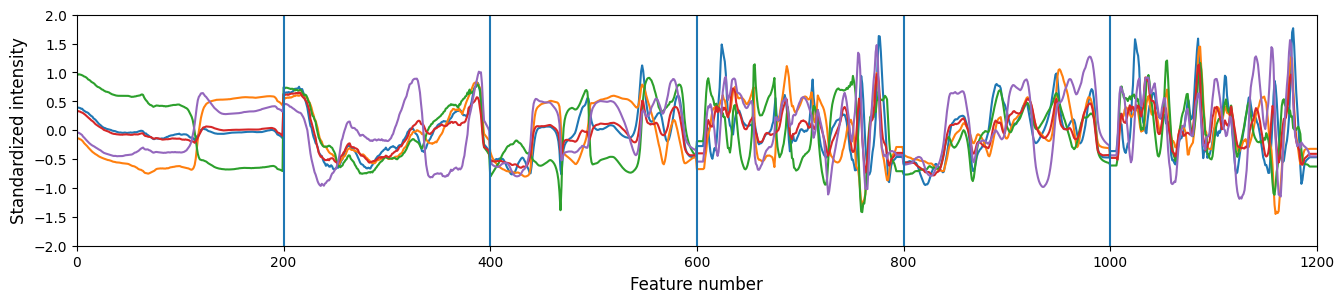

In [22]:
plt.figure(figsize=(16,3))
ax=plt.subplot()
ax.plot(x_test_scaled_col[:5,:].T)
# plt.title('column-wise scaled')
plt.xlabel('Feature number')
plt.ylabel('Standardized intensity')
plt.vlines(np.arange(1,6)*200, ymin=6, ymax=-6)
plt.xlim(0,1200)
plt.ylim(-2,2)
plt.show()


## 4) Optimizing the Learning Rate using a LR range test

The first hyperparameter that we will optimize is the Learning Rate (LR) of the gradient descent optimizer. In this tutorial we decided to do this separately from the other hyperparameters and show how to use a specific method called LR range finder. See manuscript for details.

This is also where we have our first contact with the DL model. As mentioned in the manuscript, we choose a 1D-CNN architecture composed by a single conv. layers (1 filter, and stride=1), followed by a block of dense (fully connected, FC) layers. The LR optimization requires the creation/definition of a base model (prior to CNN optimization). This enables us to have an idea about the best learning rate range that can be used during the training process. The assumption here is that the LR range extracted from this base model test will also work well with the optimized CNN. This seems to hold true if the final model CNN architecture does not differ to much from the base architecture (number of layers, range of units, etc). After the base model is created, we perform a Learning Rate Range test to infer the min and max useful LR values.

### 4.1) Define the base CNN architecture

For the base model we choose a CNN with 1 conv. layer followed by 4 dense layers. The number of units in the first 3 dense layers are defined using an empirical rule of thumb that tells us that the first dense layer should be between a half and a fourth of the input features to that layer and that the units in the following layers ones should decrease by a factor of 2 or 3. It is often assumed that this type of architecture (lik a funnel) forces the NN to synthesize the data into higher abstraction representations. The last layer (output) has 30 units that correspond to the 30 classes of wheat in our data set.


- **Weights initialization:** The units weights are initialized using the <code>he_normal()</code> initializer in tf.keras. This corresponds to a zero-mean Gaussian distribution whose standard deviation is $\sqrt{\frac{2}{n_i}}$, where $n_i$ is the number of input neurons

- **Activation functions:**  For all layers the activation function chosen is the  Exponential Linear Unit (ELU), except for the last layer that is the softmax activation function. Softmax helps transform the output values into probabilities per class which is indicated for classification purposes.

- **L2 Regularization:** L2 regularization is implemented on all layers to stabilize the gradient propagation and to decrease overfitting using <code> tf.keras.regularizers.l2(beta))</code>.  (see [tf.keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2)). 


The implementation of this model in tensorflow/keras is straightforward.<br> 


In [23]:
## Make computations reproducible
reproducible_comp()

## Create the base model to be used in LRFinder only
def create_base_model():
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_cal_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = 5
    K_STRIDE = 1
    FC1_DIMS = 512
    FC2_DIMS = 256
    FC3_DIMS = 128
    OUT_DIMS = 30
    
    ## L2 regularizer parameter
    beta= 0.003/2.
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Due to this, we might have to re-run this cell before each experiment to ensure proper weight initialization each time
    K_INIT = tf.keras.initializers.he_normal(seed=42)
    
    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## This is where the CNN architecture is define, layer after layer.
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                    keras.layers.Conv1D(filters=K_NUMBER, \
                                                        kernel_size=K_WIDTH, \
                                                        strides=K_STRIDE, \
                                                        padding='same', \
                                                        kernel_initializer=K_INIT,\
                                                        kernel_regularizer=K_REG,\
                                                        activation='elu',\
                                                        input_shape=(CONV1D_DIMS,1)), \
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(FC1_DIMS, \
                                                       kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG, \
                                                       activation='elu'),
                                    keras.layers.Dense(FC2_DIMS, \
                                                       kernel_initializer=K_INIT,\
                                                       kernel_regularizer=K_REG,\
                                                       activation='elu'),
                                    keras.layers.Dense(FC3_DIMS, \
                                                       kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG, \
                                                       activation='elu'),
                                    keras.layers.Dense(OUT_DIMS, kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG,\
                                                       activation='softmax'),
                                  ], name='BASE_MODEL')
    
    return model_cnn

Print a summary of the base model and plot the architecture

In [24]:
model_base_cnn = create_base_model()
model_base_cnn.summary()

Model: "BASE_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1200, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 1200, 1)           6         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 512)               614912    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 30)                3

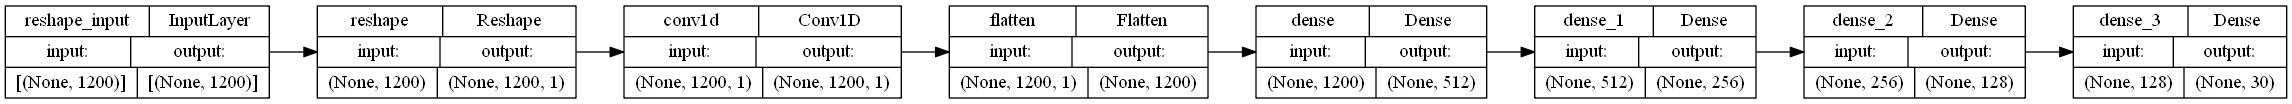

In [25]:
## Plot the CNN layer architecture 
## The plot_model() from Keras requires that graphviz and pydot are installed in your system.
## If you dont't have these libraries installed, skip this cell for now and browse for the image "base_cnn_classification.png" in the repository to see the result

plot_model(model_base_cnn,  to_file='base_cnn_classification.png', show_shapes=True, show_layer_names=True, \
          rankdir='LR', expand_nested=False, dpi=96)

Create a model with the optimized structure. This step was implemented after the optimization but is displayed here to produce a comparison of the model behavior in terms of Learning Rate range test.

### 4.2) Apply LR Range test to the base CNN

Apply LRfind to base model cnn, training with batch size = 512 and during 400 epochs. Besides defining these variables, we also need to define the:

- **Loss function:** The "categorical_crossentropy" computes the crossentropy loss between the labels and predictions.
- **Optimizer:** We use the 'Adam' optimizer here, due to its proven record of good performance.

In reality these predefined choices could be considered as hyperparameters as well and, if computational resources are not a problem, the optimization could include them. <br>
The LR Range test consists in training the model by iteratively changing the LR and by checking it the model is "learning" anything by probing the rate of change on the loss function. This might take a couple of minutes...

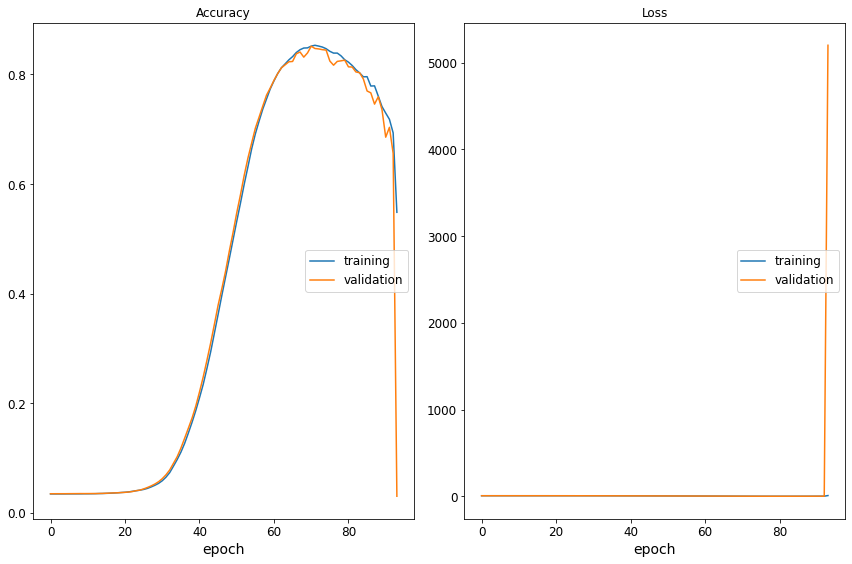

Accuracy
	training         	 (min:    0.035, max:    0.853, cur:    0.548)
	validation       	 (min:    0.031, max:    0.851, cur:    0.031)
Loss
	training         	 (min:    0.835, max:    8.791, cur:    8.791)
	validation       	 (min:    0.832, max: 5200.739, cur: 5200.739)


In [25]:
## define a step for the test
step_base=0.25*np.ceil(len(x_cal_scaled_col) / 512) * 400

## define the LR_range test object using the LRFinder() function predifined in the Help section.
lr_finder_base = LRFinder(start_lr= 1e-9, end_lr = 0.1, max_steps= step_base, smoothing=0.9)

## define a name for this model
MODEL_NAME='LR_finder_Adam_batch=_BASE_512_filter=5.h5'

## clear the session to make there is no clutter in keras
tf.keras.backend.clear_session()

## define the model and compile it using the Adam optimizer, categorical crossentropy as a loss function, and by measuring the "acc" -> accuracy
model = create_base_model()
model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['acc']) 

## Callback to visualize the training in real time
plot_losses = PlotLossesKerasTF()

## Train the model
h2=model.fit(x_cal_scaled_col, y_cal, batch_size=512, epochs=400, \
              validation_data=(x_tuning_scaled_col, y_tuning),  \
              callbacks=[lr_finder_base, PlotLossesKerasTF()],verbose=0)  


Plot the result of the LRfinder for the base model and establish the min and max LR to be used. The blue and red lines are plotted in a second iteration of this cell because one first has to check where the validation loss is lower (to find the max LR) and where the valiation loss starts to decrease (to define the min LR). In this case we chose LRmin = 1e-7.

(1e-09, 0.04)

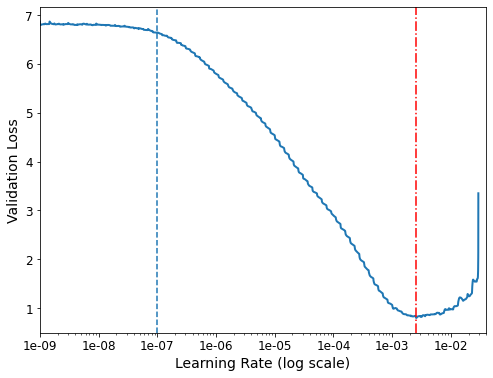

In [26]:
lr_finder_base.plot()
plt.axvline(1e-7, ls='dashed')
plt.axvline(0.0025, ls='dashdot', color='r')
plt.ylabel('Validation Loss')
plt.xlim(1e-9,4e-2)

This LR range test gives us an idea how our model "learns" as a function of LR. In the beginning of the test (lower LR) the model has a high validation loss, meaning that during the 400 used epochs the model is unable to learn anything. For values of LR above LRmin, the validation loss begins to drop. The bigger the LR gets, the better is the improvement and the validation loss stats to decrease until it reaches a valley from LR = 1e-3 to LR = 1e-2. After that it spikes up again indicating that the LR is too high and therefore the gradient descent algorithm cannot "lock down" on a particular minimum eventually leading to a "gradient explosion".

### 4.3 Compute the base model performance

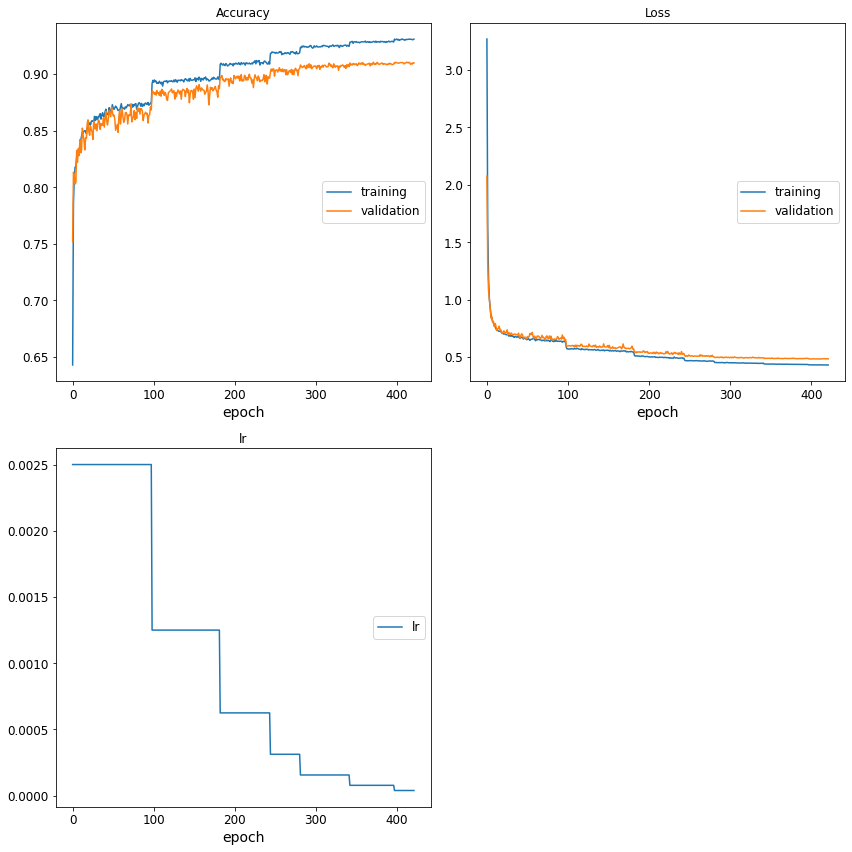

Accuracy
	training         	 (min:    0.643, max:    0.931, cur:    0.931)
	validation       	 (min:    0.752, max:    0.910, cur:    0.910)
Loss
	training         	 (min:    0.430, max:    3.270, cur:    0.430)
	validation       	 (min:    0.482, max:    2.075, cur:    0.483)
lr
	lr               	 (min:    0.000, max:    0.002, cur:    0.000)

Metrics for based CNN 
Training  Acc. ->  0.9301111111111111
Tuning  Acc. -> 0.910375
Test Acc. ->  0.9090444035195416


In [27]:
#######  Callbacks #########
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-7, monitor='val_acc', verbose=1)
## Create new model with optmized hyperparamters
model_base = create_base_model() 

## Compile the model using the LRmax for the LR in Adam() 
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              loss="categorical_crossentropy", metrics=["acc"])
  
## Train new model using optimal batch size. Extend the epochs a bit to see if results improve
history0 = model_base.fit(x_cal_scaled_col, y_cal, batch_size=512, epochs=550, \
          validation_data=(x_tuning_scaled_col, y_tuning),\
          callbacks=[rdlr, early_stop, PlotLossesKerasTF() ], verbose=0)


## Make predictions on the train, tuning and test sets
pred_cal_base = model_base.predict(x_cal_scaled_col)
pred_val_base = model_base.predict(x_tuning_scaled_col)
pred_test_base = model_base.predict(x_test_scaled_col)

test_Yhat_base = np.argmax(pred_test_base,axis = 1)
cal_Yhat_base = np.argmax(pred_cal_base,axis = 1)
val_Yhat_base = np.argmax(pred_val_base,axis = 1)

## Compute accuracies
TestAcc_base = accuracy_score(pre_labels, test_Yhat_base)
CalAcc_base = accuracy_score(cal_labels, cal_Yhat_base)
ValAcc_base = accuracy_score(val_labels, val_Yhat_base)

print('\nMetrics for based CNN ')
print('Training  Acc. -> ', CalAcc_base)
print('Tuning  Acc. ->', ValAcc_base)
print('Test Acc. -> ', TestAcc_base)

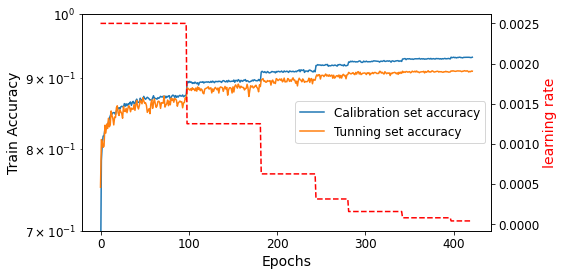

In [28]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(history0.history['acc'], label='Calibration set accuracy')
plt.plot(history0.history['val_acc'], label='Tunning set accuracy')
plt.yscale('log')
plt.ylabel('Train Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.7,1)
plt.legend(loc=5)
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(history0.history['lr'], 'r--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.show()
# plt.savefig('train_tun_loss.png', dpi=96)

## 5) Optimization of the model hyperparameters with Optuna
In this section we perform the optimization of several model hyperparameters and make a few tweaks to the model architecture (NAS) by exploring different number of dense (or fully connected, FC) layers, dropout layers, etc.
The optimization uses the Hyperband and TPE algorithms implemented in the Optuna package. In the website https://optuna.org/ you can find several examples on how to use Optuna for different settings and problems.

### 5.1) Define the CNN model
We start by redifining the CNN in a similar process done for the LR Range test. This base architecture iteratively builds the dense and dropout layers through the optimization process. The same activations and L2 regularization are used as before.
This time the model is defined in terms of the model's hyperparameters that we want to optimize: **number of dense layers, number of units per dense layers, convolution filter size, dropout rate, strength of the L2 regulatization.** In addition, during the optimization process we will also optimize the **training batch size**.

In [5]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_cal_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = 30  ## Number of classes in the data


    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta/2.
    K_REG = tf.keras.regularizers.l2(beta)

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=42)

    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='NEW_MODEL')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))

    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))

    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    ## followed by a dropout layer (with a certain dropout rate)
    ## The number of layers, units, dropout rate, etc. will be optmized. Note that a dropout rate = 0 is
    ## the same as excluding that dropout layer... 

    ## #BUG ALERT: the range in the following FOR loop should start at 0 ############
    ## The following line should be:
    ## for i in range(0,num_FC_layers):
    for i in range(1,num_FC_layers):
        model_cnn.add(keras.layers.Dense(num_FC_units[i], \
                                         kernel_initializer=K_INIT, \
                                         kernel_regularizer=K_REG,\
                                         activation='elu', name='DENSE'+str(i)))
        model_cnn.add(keras.layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i)))  

    ## Final layer for multi-label classification (does not count for the number of optimizable DENSE layers)
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='softmax', name='OUTPUT'))
    
    return model_cnn 

### 5.2) Optimize the model hyperparameters

This is where the bulk of the optimization is done.  

First we define the callbacks that will not be changed during the optimization. These are the `EarlyStopping()`, `ReduceLROnPlateau()`, `TQDMProgressBar()` and a custom version of `ModelCheckpoint()` that only saves models after they trained more than 150 epochs. This way, all the models that will be pruned (stopped after few training epochs) will not be saved to the disk.

In [27]:
## import the callback from optuna that allows tensorflow to do something analogous to early_stopping but
## commanded by the hyperband algorithm.
from optuna.integration import TFKerasPruningCallback

## Set the path where the computed models are saved
## Beware of path notation differences between windows (\\) and linux (/) systems
path='classification_models\\'

## list for additional metrics
metricas=[]

#######  Callbacks #########
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-7, monitor='val_acc', verbose=1)

progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

## Subclass ModelCheckpoint -  Custom ModelCheckpoint to save models only after a certain number of epochs (to save resources)
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

    ## redefine the save so it only activates after 150 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 150: super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)

This is one of the most important parts of the optimization. In the function `objective()` we define the range of search for each hyperparameter and the objective function that the BO will try to optimize. In this case we want that our model performs well (high accuracy) on the tuning set.

<font color='red'> Since Optuna 3.0.0 the method suggest_discrete_uniform() has become deprecated. To avoid warnings we follow Optuna's suggestion and use suggest_int() instead. </font>

In [7]:
######### Define the objective function to monitor during optimization, set the hyperperameters ranges, etc. #########
def objective(trial):
    
    ## Clear clutter from previous session   
    keras.backend.clear_session()
    
    ## define the model name as the study object + the trial number. It facilitates model retrieval in the post-optimization process
    MODEL_NAME='ClassStudy0_trial='+str(trial.number)+'.h5' 
    
    ## Number of FC layers
    NUM_FC_LAYERS = trial.suggest_int("num_FC_layers",1,5, step=1)
    
    ## #BUG ALERT: The following line should be:
    ## NUM_FC_UNITS = [int(trial.suggest_int("num_FC_UNITS_"+str(i), 128, 512, step=2)) for i in range(0, NUM_FC_LAYERS)]
    ## Number of units per layer
    NUM_FC_UNITS = [int(trial.suggest_int("num_FC_UNITS_"+str(i), 128, 512, step=2)) for i in range(NUM_FC_LAYERS)]
    
    ## Filter size  (K_WIDTH)
    FILTER_SIZE = int(trial.suggest_int("filter_size", 3, 20, step=1)) 
    
    ## #BUG ALERT: The following line should be:
    ## DROPOUT_RATE=  [trial.suggest_float("DROPOUT_"+str(i), 0., 0.6, step=0.005) for i in range(0, NUM_FC_LAYERS)]
    ## Dropout rate (DROPOUT)
    DROPOUT_RATE=  [trial.suggest_float("DROPOUT_"+str(i), 0., 0.6, step=0.005) for i in range(NUM_FC_LAYERS)]

    ## L2 regularization
    REG_BETA = trial.suggest_float("reg_beta", 2E-6, 0.003, step=0.00001)
    
    ## Instatiate the model
    model = create_model(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, REG_BETA)
    
    ## Add batch size to the hyperparameters to be optimized. This hyperparameter is not used directly by the model()
    ## but is used in the training phase.
    BATCH_SIZE = int(trial.suggest_int("batch_size", 128, 1024, step=64))
    trial.set_user_attr("batch_size", BATCH_SIZE)
    
    ## Compile the model
    ## Note: the learning_rate in Adam() is set to the max LR found in the LRFinder test
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
          loss="categorical_crossentropy",
          metrics=["acc"])
        
    ## Instead of the following custom callback, you can use the default version 
    ## checkpointer = keras.callbacks.ModelCheckpoint(filepath=path+MODEL_NAME, verbose=1, save_best_only=True)
    custom_checkpointer = CustomModelCheckpoint(filepath=path+MODEL_NAME, verbose=0, save_best_only=True)  
    
    ## Train the model on train data and validate it on tuning (val) data
    ## Note: The callback TFKerasPruningCallback(trial, 'val_acc') is necessary to convey val_acc info to the Hyperband pruner
    history = model.fit(x_cal_scaled_col, y_cal, batch_size=BATCH_SIZE, epochs=450, \
                  validation_data=(x_tuning_scaled_col,y_tuning), callbacks=[rdlr, early_stop, custom_checkpointer, \
                             TFKerasPruningCallback(trial, 'val_acc'), progressbar], verbose=0)
    
    ## Compute auxiliary metrics
    scores_tuning = model.evaluate(x_tuning_scaled_col, y_tuning, verbose=0)
    scores_train = model.evaluate(x_cal_scaled_col, y_cal, verbose=0)
    print('Train accuracy={}'.format(scores_train[1]))
    print('Tuning accuracy={}'.format(scores_tuning[1]))
    
    ## We set the accuracy on the tuning set as the objective function to be optimized
    return scores_tuning[1]

<div class="alert alert-block alert-info">
<b>Note: </b>The previous cell is where we define the hyperparameters that are going to be optimized. If the reader wants to expand the number of hyperparameters to be optimized, it is straight forward to modify the previous script to include other hyperparameters. For example an interval for the number of filters (e.g. 
    <br>
    <code>     num_filters = int(trial.suggest_int("num_filters", 1, 4, step=1))</code> ) 
<br>or the type of activation function per layer (e.g. 
    <br>
    <code>     activ_func = trial.suggest_categorical("activ_func", ['elu', 'relu', 'sigmoid'])</code>
). <br>If that is the case, the reader also has to modify the create_model() function accordingly, e.g. 
    <br>
    <code>     create_model(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta, num_filters, activ_func)</code>.
</div> 
    
<div class="alert alert-block alert-warning">
If you skipped the regression tutorial, you can go check it if you want a more detailed/alternative information of what is presented in the next cells.
</div>     

The next cell runs the optimization and logs the results into a database .db file that can be monitored in real time with the optuna-dashboard or analysed post-optimization. Depending on the number of trials defined and the hardware where this is running, this process might take several hours. If you want to skip ahead and go directly for the results, don't run the next two cells and jump to **Section 6)**.

<div class="alert alert-block alert-warning">
In this next cell we create the <code>study</code> object named <font color='red'>"CalssStudy0_v2"</font>. If a study with the same name has already been created, Optuna will add the new trials to that object, i.e., the optimization process will be resumed from a previous optimization session. For this reason, in this tutorial, the final results from our (the authors) initial optimization has been renamed as "ClassStudy0_precomputed_v2.db" in the attached files.
</div>  

In [ ]:
## enable the log of the data
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

## define the name of the "study" that Optuna will perform by looking at multple "trials" of the "objective" function
study_name = "ClassStudy0_v2"
## create data base entry for saving the intermidiate results of the optimization
storage_name = "sqlite:///{}.db".format(study_name)

## Create a study that will MAXIMIZE the objective function previously defined (accuracy of the tuning set).
## We use TPE with a cte seed (for reproducibility) and n_startup_trials = 50 (random search picks) to 
## warm up the BO. In this study we also enable multivariate=True in order for the TPE alg. to look for
## relatioships between hyperparameters (it creates multivariate kernel densities instead of single kernel
## densities). This last step is not crucial but it seems to help. Pruning is done with the HyperBand algorithm 
## and we allocate a min_resource of 50 epochs per model to guarantee that the convergence 
## level is high enough to ensure reliable solutions.
ClassStudy0_v2 = optuna.create_study(study_name=study_name, \
                             storage=storage_name,  \
                             direction='maximize',  \
                             sampler = optuna.samplers.TPESampler(seed=42, 
                                                                 consider_endpoints=True, 
                                                                 multivariate=True,
                                                                 n_startup_trials=50),\
                             pruner=optuna.pruners.HyperbandPruner(min_resource=50, reduction_factor=4),\
                             load_if_exists=True)


## In the case we have already found (by trial and error) some nice hyperparameters, we can 
## enqueue them into the hyperparameter search space. This way the pruner will be more effective
## because the search will start from an already good solution (high accuracy in this case). 
## Some initial good values found in previous benchmark are: 
ClassStudy0_v2.enqueue_trial({"num_FC_layers": 4,
                       "num_FC_UNITS_0": 288, 
                       "num_FC_UNITS_1": 416, 
                       "num_FC_UNITS_2": 490, 
                       "num_FC_UNITS_3": 262,
                        "filter_size":3,
                       "DROPOUT_0":0.26,
                       "DROPOUT_1":0.26,
                       "DROPOUT_2":0.26,
                       "DROPOUT_3":0.26,
                       "reg_beta":2e-6,
                       "batch_size":832,
                       })
## In the case we start from scratch without any knowledge of the hyperparameters, the previous lines
## can just be commented.

## For exemplification purposes we start the optimization with a Budget of 500 trials. 
## Your computational resources, available time and patience will determine the right number of trials to test!
ClassStudy0_v2.optimize(objective, n_trials=500)

## IMPORTANT NOTE: For simplification of the notebook visualization online the output of this cell has been omitted.
## The output of this cell has been copied into file classification_log.txt

<div class="alert alert-block alert-warning">
The output of the previous cell was removed to improve the online readability of the notebook. Ignore this warning if you are running this yourself.
    
The remainder of **Section 5)** assumes that the user ran the optimization cell and generated his own <code>ClassStudy0_v2</code>.    
</div> 

<font color='red'>v2 - Remember, since we set the seed=42 in the optuna.samplers.TPESampler(seed = 42...) function, your own run results should not differ too much from the present results. Off course there is always gradient descent related variations in the training of the CNNs but that is another issue that can be resolved by enabeling new determininm flags in Tensorflow, see: https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism <br></font>

Once the study is completed, we can run the following command to explore the best hyperparameters found during the optmization:

In [33]:
print('Best trial =', ClassStudy0_v2.best_trial.number)
print('Best trial accuracy =', ClassStudy0_v2.best_trial.values[0]) ## i.e. the tuning accuracy
print('\nBest model hyperparameters:')
ClassStudy0.best_params 

Best trial = 454
Best trial accuracy = 0.949999988079071

Best model hyperparameters:


{'DROPOUT_0': 0.555,
 'DROPOUT_1': 0.165,
 'DROPOUT_2': 0.13,
 'DROPOUT_3': 0.46,
 'DROPOUT_4': 0.085,
 'batch_size': 896,
 'filter_size': 3,
 'num_FC_UNITS_0': 360.0,
 'num_FC_UNITS_1': 350.0,
 'num_FC_UNITS_2': 132.0,
 'num_FC_UNITS_3': 442.0,
 'num_FC_UNITS_4': 334.0,
 'num_FC_layers': 5,
 'reg_beta': 1e-05}

We can now instantiate a model using <code>create_model</code> and using the hyperparameters found in the optimization. After the model is instantiated (i.e. its architecture has been defined) we load the weights of the pre-trained model that we saved during the optimization process. This model is then used to make predictions and test the validity of the model in the test set.

## 6) Post-optimization analysis and final model predictions
At any point we can stop the optimization and analyze the results obtained so far by loading the pre-saved optimization study. Optuna provides a wide range of plotting commands that are useful to visualize the optimization results. In these next cells, we show how to analyze the result of the optimization. 

<font color='red'> The current version of optuna uses a different storage format for the database objects .db. The previous format can be converted to the current standard. We did this for the .db file generated in the original notebook by using the command: <code> optuna storage upgrade --storage sqlite:///ClassStudy0_precomputed.db </code> and by renaming this file to ClassStudy0_precomputed_v2.db. In this notebook you can either import ClassStudy0_precomputed_v2.db (the format upgraded previous version) or other XXX.db (e.g. ClassStudy0_v2.db) file that you have generated.</font>

In [29]:
## Load a pre-computed optimization study
saved_study = optuna.study.load_study(storage="sqlite:///ClassStudy0_precomputed_v2.db", study_name="ClassStudy0")

## Substitute the previous line by this one if you want check the ClassStudy0 that you generated
# saved_study = optuna.study.load_study(storage="sqlite:///ClassStudy0.db", study_name="ClassStudy0")

Check the best value for the objective function and the corresponding hyperparameters (just repeating the previous method)

In [30]:
print('Best trial =', saved_study.best_trial.number)
saved_study.best_params 

Best trial = 454


{'DROPOUT_0': 0.555,
 'DROPOUT_1': 0.165,
 'DROPOUT_2': 0.13,
 'DROPOUT_3': 0.46,
 'DROPOUT_4': 0.085,
 'batch_size': 896,
 'filter_size': 3,
 'num_FC_UNITS_0': 360.0,
 'num_FC_UNITS_1': 350.0,
 'num_FC_UNITS_2': 132.0,
 'num_FC_UNITS_3': 442.0,
 'num_FC_UNITS_4': 334.0,
 'num_FC_layers': 5,
 'reg_beta': 1e-05}

The optimization result (over 500 trials) shows that the best results are obtained with model that has 5 hidden FC + dropout pairs, weak regularization strength (reg_beta ~e-5), large baches (896) and small convolution kernel width (3).

### 6.1) Making predictions with the optimized model
**Method 1)** Now that we have the best hyperparameters, we can use them to find the performance of the model in our test set. Since all the trained models tested during the optimization were saved (in. h5 format), the easiest way to make predictions is to load the best pre-trained model and use it on the test set for prediction. In this case, the best trial was trial **454**. The corresponding pre-trained model is available in the <mark>*classification_models/pre-trained/*</mark> folder under the name **ClassStudy0_trial=454.h5**. In the next cell, this model is loaded and the corresponding prediction on the test set is done.

In [31]:
## #BUG ALERT: In the following definition of model454, the first values of the lists [360,350,132,442,334], [0.555,0.165,0.13,0.46,0.085] are not
## used by the CNN. This will change in the future. The values cannot be simply erased because of the indexing but can be substituted by an _.

## Instantiate a model using the best hyperparameters found in the optimization
model454 = create_model(5, [360,350,132,442,334], 3, [0.555,0.165,0.13,0.46,0.085], 1e-05)
## Load the pre-trained weights into the model
model454.load_weights('classification_models\pre-trained\ClassStudy0_trial=454.h5') 

 
## Make predictions on the train, tuning and test sets
pred_cal= model454.predict(x_cal_scaled_col)
pred_val= model454.predict(x_tuning_scaled_col)
pred_test= model454.predict(x_test_scaled_col)

test_Yhat = np.argmax(pred_test,axis = 1)
cal_Yhat = np.argmax(pred_cal,axis = 1)
val_Yhat = np.argmax(pred_val,axis = 1)

## Compute accuracies
TestAcc = accuracy_score(pre_labels, test_Yhat)
CalAcc = accuracy_score(cal_labels, cal_Yhat)
ValAcc = accuracy_score(val_labels, val_Yhat)

print('Training  Acc. -> ', CalAcc)
print('Tuning  Acc. ->', ValAcc)
print('Test Acc. -> ', TestAcc)

1222/1222 [==============================] - 2s 1ms/step
Training  Acc. ->  0.9900416666666667
Tuning  Acc. -> 0.9489583333333333
Test Acc. ->  0.9458256599140578


The optimization process allowed us to bump the performance of our base model from an accuracy of 0.908 to an accuracy of 0.946 on the test set.

Additionally we can check how the model performs for every of the 30 classes of wheat labels individually

In [38]:
## Load the sklearn function to generate the classification report
from sklearn.metrics import classification_report

## print the report by comparing the tru labels (pre_labels) with the predicted labels (test_Yhat)
print(classification_report(pre_labels, test_Yhat))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1054
           1       0.99      0.99      0.99      1431
           2       0.97      0.97      0.97      1332
           3       0.91      0.92      0.91      1335
           4       0.91      0.83      0.87      1259
           5       0.91      0.91      0.91      1277
           6       0.96      0.95      0.95      1355
           7       0.90      0.87      0.88      1353
           8       0.92      0.95      0.93      1360
           9       0.97      0.99      0.98      1361
          10       0.91      0.91      0.91      1283
          11       0.82      0.89      0.85      1273
          12       0.88      0.89      0.89      1280
          13       0.98      0.98      0.98      1134
          14       0.89      0.88      0.89      1356
          15       0.99      0.98      0.98      1356
          16       0.99      0.99      0.99      1353
          17       0.99    

**Method 2)** If the user decided not to save every model tested during the optimization (it will speed up the computation a bit), he/she could instead instantiate a model with the optimized hyperparameters and train it again. This can be done using the same calibration/tuning split used in the optimization phase or, we can aggregate back the calibration and tuning data into a single training set and re-train the model on all the available training data. This alternative is what we present in the next cell. Please note that due to the nature of stochastic gradient descent, the final accuracies might change a small bit, from run to run.

In [37]:
## Check (N,M) dimensions of the data sets 
print(np.shape(x_cal_scaled_col))
print(np.shape(y_cal))
print(np.shape(x_tuning_scaled_col))
print(np.shape(y_tuning))

(72000, 1200)
(72000, 30)
(24000, 1200)
(24000, 30)


In [41]:
## Concatenate the calibration and tuning sets into a single train set
x_train_scaled_col = np.concatenate([x_cal_scaled_col, x_tuning_scaled_col], axis=0)
y_train = np.concatenate([y_cal, y_tuning], axis=0)
train_labels = np.concatenate([cal_labels, val_labels], axis=0)
## print the dimensions of the new aggretated train set to make sure that the concatenation is done in 
## the right axis.
print(np.shape(x_train_scaled_col))
print(np.shape(y_train))

(96000, 1200)
(96000, 30)


<div class="alert alert-block alert-warning">
<b>Note</b>: Please note that this time there is no tuning/validation set, so, we have to modify the callbacks EarlyStopping() and ReduceLROnPlateau() to monitor the model  accuracy <code>('acc')</code> instead of the model's validation accuracy <code>('acc_loss')</code>. The same applies to ModelCheckpoint(). Our initial modeling strategy is based on the assumption that the model generalizes better if it is forced to adapt the LR as a function of performance on the validation/tuning data (tuning accuracy). By not using a validation/tnning set, we cannot be sure that the LR that will be defined iteratively by ReduceLROnPlateau() will contribute to better model generalization as before! This strategy of retrain the model on the full training set tend to present better results when the LR is kept fixed during the train. For these cases, LR can also be one of the hyperparameters that are optimized by the Bayesian optimization loop.

One other thing that we can do is to load the weights of the best model found so far and use those weights to initialize the training on the full train set for a some additional epochs. This way we start the CNN optimization near a good error minimum in the error loss landscape.
</div>   

<div class="alert alert-block alert-warning">
As it was noted in the final stages of the "regression tutorial", starting the train after loading the weights of an optimized model, might result in noise / jitter of the computation of the model's loss in the initial training phase. A too large learning rate, when we are already zoomed in into an error minimum might induce gradient descent to jump around and jump out of that minimum region. To avoid that, we can use a LR smaller than LRmax.
</div>

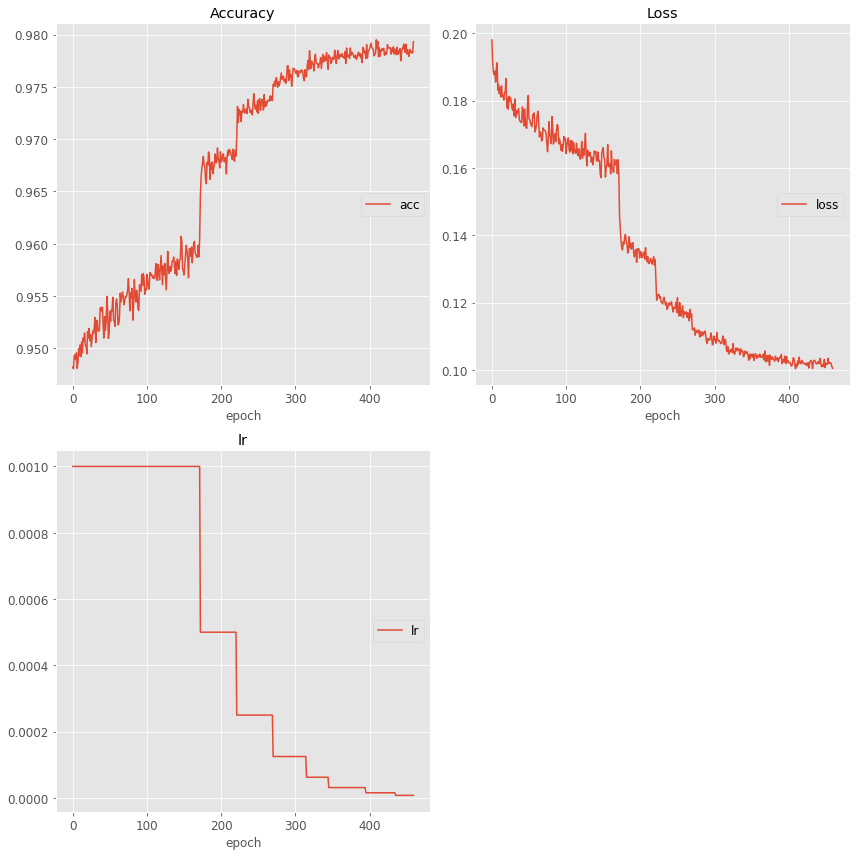

Accuracy
	acc              	 (min:    0.948, max:    0.979, cur:    0.979)
Loss
	loss             	 (min:    0.100, max:    0.198, cur:    0.101)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)

Metrics for final CNN 
Training  Acc. ->  0.996
Test Acc. ->  0.9521178637200737


In [61]:
## Clear clutter from previous session   
keras.backend.clear_session()


#######  Callbacks #########
early_stop = keras.callbacks.EarlyStopping(monitor='acc', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-7, monitor='acc', verbose=1)

## #BUG ALERT: In the following definition of model454, the first values of the lists [360,350,132,442,334], [0.555,0.165,0.13,0.46,0.085] are not
## used by the CNN. This will change in the future. The values cannot be simply erased because of the indexing but can be substituted by an _.
## Create new model with optmized hyperparamters
model_new = create_model(5, [360,350,132,442,334], 3, [0.555,0.165,0.13,0.46,0.085], 1e-05)

## Load the weights of the best pre-trained model for initialization
model_new.load_weights('classification_models/pre-trained/ClassStudy0_trial=454.h5') 

## Compile the model using an LR less than half of the LRmax in Adam() 
model_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["acc"])

MODEL_NAME='final_classification_model.h5'
checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=1, save_best_only=True)

## Train new model using optimal batch size. Extend the epochs a bit to see if results improve
history_new = model_new.fit(x_train_scaled_col, y_train, batch_size=896, epochs=600, \
          callbacks=[rdlr, checkpointer, early_stop, PlotLossesKerasTF() ], verbose=0)


## Make predictions on the train, test sets
pred_train_new = model_new.predict(x_train_scaled_col)
pred_test_new = model_new.predict(x_test_scaled_col)

train_Yhat_new = np.argmax(pred_train_new,axis = 1)
test_Yhat_new = np.argmax(pred_test_new,axis = 1)


## Compute accuracies
TrainAcc_new = accuracy_score(train_labels, train_Yhat_new)
TestAcc_new = accuracy_score(pre_labels, test_Yhat_new)

print('\nMetrics for final CNN ')
print('Training  Acc. -> ', TrainAcc_new)
print('Test Acc. -> ', TestAcc_new)

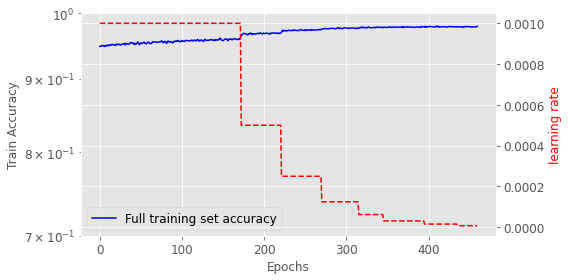

In [62]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(history_new.history['acc'], 'b',label='Full training set accuracy')
plt.yscale('log')
plt.ylabel('Train Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.7,1)
plt.legend(loc=3)
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(history_new.history['lr'], 'r--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.show()
# plt.savefig('train_tun_loss.png', dpi=96)

### 6.2) Extra visualizations of the optimization process

These next cells show the potential of Optuna visualization tools. We can plot slices of the optimization procedure and see how the different hyperparameters where optimized. The blue shading allows for a sense of evolution. We can see that lighter colors (begining of the optimization) get lower accuracies, and as the optimization progresses, the hyperparameters start to get higher and higher accuracies. Now remember, that the accuracies we are viewing here are the accuracies on the tuning set. The true accuracy of the model in the test set is still not determined at this point. If a couple of warnings related to optuna's "experimental features" pop in, don't worry.

<div class="alert alert-block alert-warning">
<font color='red'>You might need to change the object name to "ClassStudy0_v2" if you want to look at your optimization or use "loaded_study" for the previous study loaded earlier (depending on your work flow so far).</font>
</div>    

C:\Users\dmcp\AppData\Local\Temp\ipykernel_11180\4133615251.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(saved_study, params=["num_FC_UNITS_0", "num_FC_UNITS_1", "num_FC_UNITS_2","num_FC_UNITS_3", "num_FC_UNITS_4"], target_name='Validation Accuracy')
C:\Users\dmcp\AppData\Local\Temp\ipykernel_11180\4133615251.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(saved_study, params=["DROPOUT_0", "DROPOUT_1", "DROPOUT_2","DROPOUT_3", "DROPOUT_4"], target_name='Validation Accuracy')
C:\Users\dmcp\AppData\Local\Temp\ipykernel_11180\4133615251.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(saved_study, params=["reg_beta","filter_size","batch_size"], 

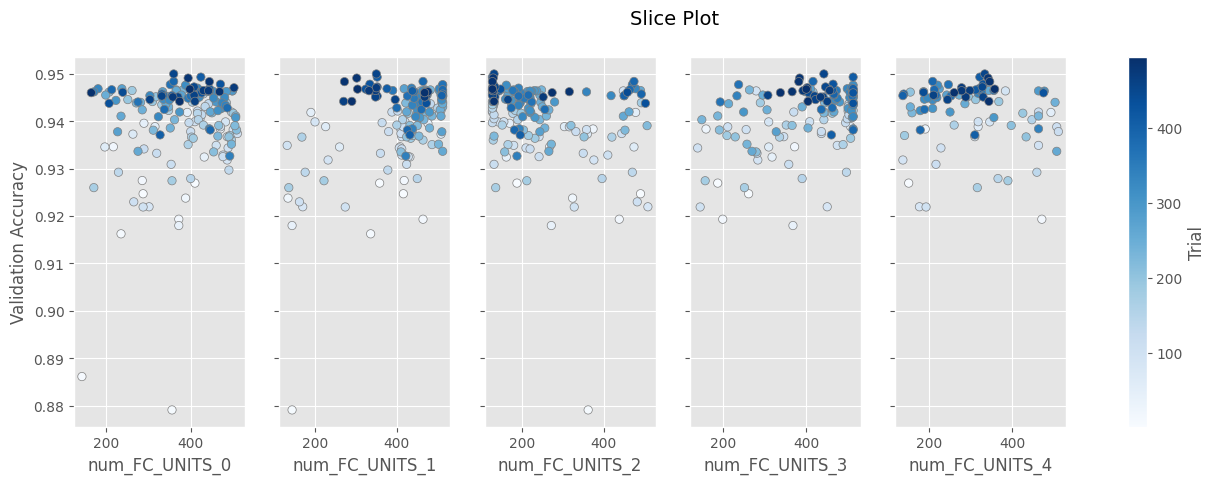

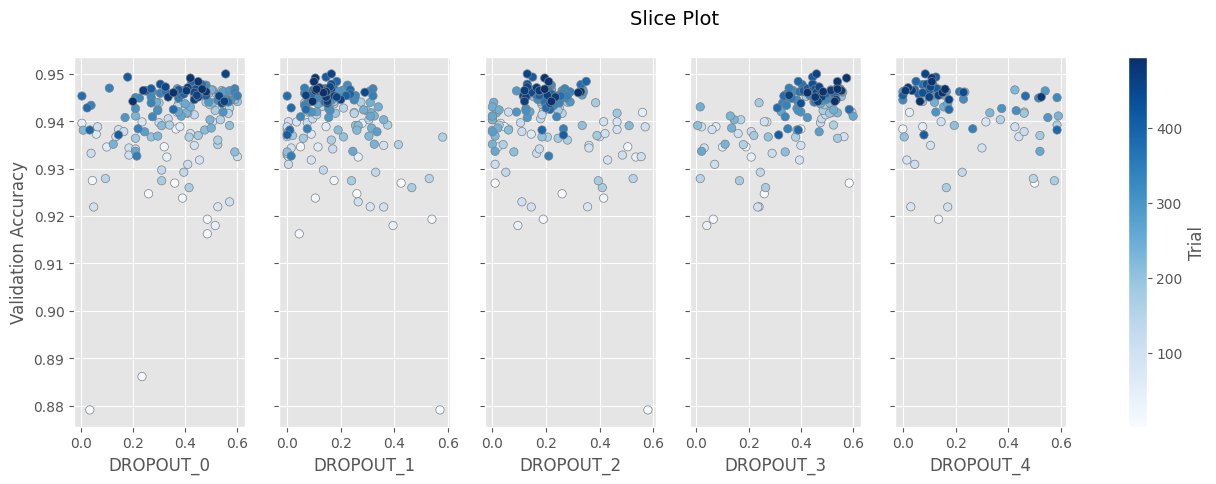

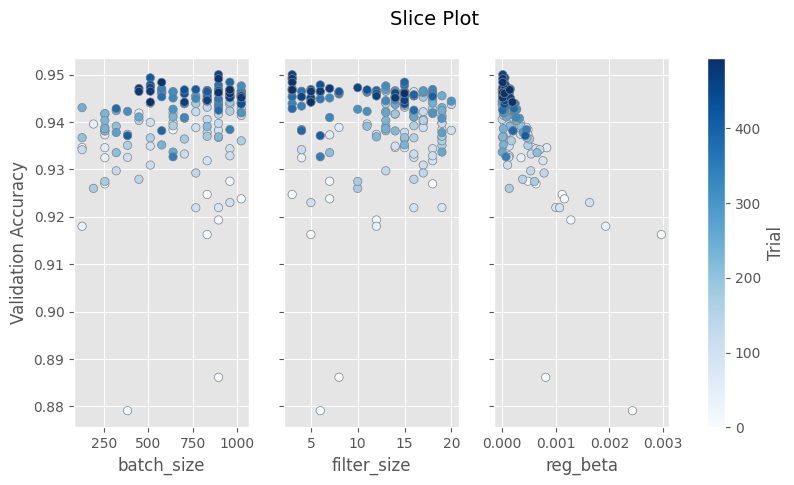

In [32]:
optuna.visualization.matplotlib.plot_slice(saved_study, params=["num_FC_UNITS_0", "num_FC_UNITS_1", "num_FC_UNITS_2","num_FC_UNITS_3", "num_FC_UNITS_4"], target_name='Validation Accuracy')
optuna.visualization.matplotlib.plot_slice(saved_study, params=["DROPOUT_0", "DROPOUT_1", "DROPOUT_2","DROPOUT_3", "DROPOUT_4"], target_name='Validation Accuracy')
optuna.visualization.matplotlib.plot_slice(saved_study, params=["reg_beta","filter_size","batch_size"], target_name='Validation Accuracy')
plt.show()

Plotting the accuracy as a function of optimization trials. In the following graphic we can see that after trial ~ 454 the optimization process hits a plateau.

C:\Users\dmcp\AppData\Local\Temp\ipykernel_11180\2324004386.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(saved_study)


(-20.0, 520.0)

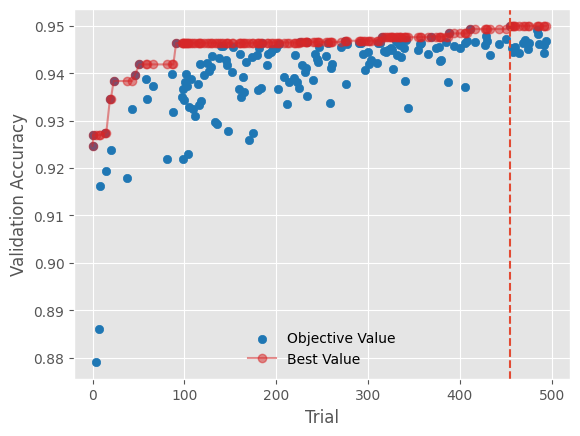

In [34]:
optuna.visualization.matplotlib.plot_optimization_history(saved_study)
plt.title('')
plt.axvline(454, ls='dashed')
plt.ylabel('Validation Accuracy')
plt.legend(frameon=False)
plt.xlim(-20,520)
# plt.yscale('logit')
# plt.show()
# plt.savefig("optimization_history.eps",format='eps',bbox_inches = 'tight', pad_inches = 0)

If you are interested in more visualizations of your optimization study, please consult the Optuna documentation:<br>
<url>https://optuna.readthedocs.io/en/stable/reference/index.html</url>

## 7) GradCAM implementation

The GradCAM technique might be useful for certain architectures because it allows to infer information about the wavelengths that contributed the most for the classification process. We believe that this is the case for the CNN architecture used here because gradCAM computes the gradient of the error backwards all the way to the last convolution layer and by that process, it traces back the most important features extracted by that last conv. layer. For this specific architecture, with a single conv. layer with 1 kernel and a stride of 1, the output feature of the conv. layer map the input values directly, and because of that, a relationship with the wavelengths can be establish. For CNN architectures with two or more conv. layers, the input signal is encoded into higher and higher abstractions/features from layer to layer, and it might not be possible to trace back what features of the last conv. layer map into what input wavelengths. 
In what follows, we use some of the function defined in the Help section to apply gradCAM to our model and data.

It is assumed that you have been following the tutorial sequentially and you have executed the previous cells where the model is defined.

Initialize the CNN model with the hyperparameters for the best model found in the Optimization Section and load weights from the best model of the benchmark

In [61]:
## #BUG ALERT: In the following definition of model454, the first values of the lists [360,350,132,442,334], [0.555,0.165,0.13,0.46,0.085] are not
## used by the CNN. This will change in the future. The values cannot be simply erased because of the indexing but can be substituted by an _.
## Initialize and load precomputed weights for best model (if it was done already) 
model454 = create_model(5, [360,350,132,442,334], 3, [0.555,0.165,0.13,0.46,0.085], 1e-05)
model454.load_weights('classification_models/pre-trained/ClassStudy0_trial=454.h5') 
## print model layers names and number of parameters
model454.summary()

Model: "NEW_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (Reshape)              (None, 1200, 1)           0         
_________________________________________________________________
CONVOLUTIONAL (Conv1D)       (None, 1200, 1)           4         
_________________________________________________________________
FLATTEN (Flatten)            (None, 1200)              0         
_________________________________________________________________
DENSE1 (Dense)               (None, 350)               420350    
_________________________________________________________________
DROPOUT1 (Dropout)           (None, 350)               0         
_________________________________________________________________
DENSE2 (Dense)               (None, 132)               46332     
_________________________________________________________________
DROPOUT2 (Dropout)           (None, 132)               0 

### 7.1) Compute GRAD-CAM on the different spectra per class
A few samples were pre-selected already in section 3.2. We compare the prediction made by the model with their true value

In [63]:
## Predict labels of pre-selected samples using the optimized model
predict_samples_class = model454.predict(samples_SpecClass_scaled_col)

## Print labels and predictions side by side
print(np.shape(predict_samples_class))
print('Pred. class \t True class')
for i in np.arange(len(predict_samples_class)):
    print(np.argmax(predict_samples_class[i,:]),'\t\t', samples_Labels[i])

(5, 30)
Pred. class 	 True class
2 		 2
5 		 5
10 		 10
14 		 14
19 		 19


The model correctly predicts the class of the samples spectra we chose initially! <br> We now proceed to compute the GRAD-Cam scores for these 5 samples. <br>
**Warning:** Make sure the name of the last conv. layer is correct in the function make_gradcam_heatmap(...). Check layer name in previous model.summary()

In [67]:
## Compute the grad-CAM / heatmap for each of the spectra and add them to a list
heatmaps=[]
for spec in samples_SpecClass_scaled_col:
    ## compute gradcam heatmap for model model454 and the last conv. layer named "CONVOLUTIONAL" in the model
    hmap = make_gradcam_heatmap(spec.reshape(1,-1), model454,'CONVOLUTIONAL')
    ## Set transients to zero...
    ## These transients are artifact due to the concatenation of the pre-processing data types in the data. Remember that
    ## the data being used in this notebook is a concatenation of spectra, SNV, 1st deriv., etc. In the case of using 
    ## regular spectral data (or a single pre-processed version of it, the following line should be commented)
    hmap[[0,199,200,400,600,800,1000,-1]]=0
    ## Slightly smooth the heatmaps to decrease the effect of sharp peaks in the normalization that follows
    hmap_smooth = savgol_filter(hmap,3,1,deriv=0)
    ## normalize the heatmaps
    hmap_norm = np.maximum(hmap_smooth, 0)  
    hmap_scaled = (hmap_norm - hmap_norm.min()) / (hmap_norm.max() - hmap_norm.min())  
    heatmaps.append(hmap_scaled)

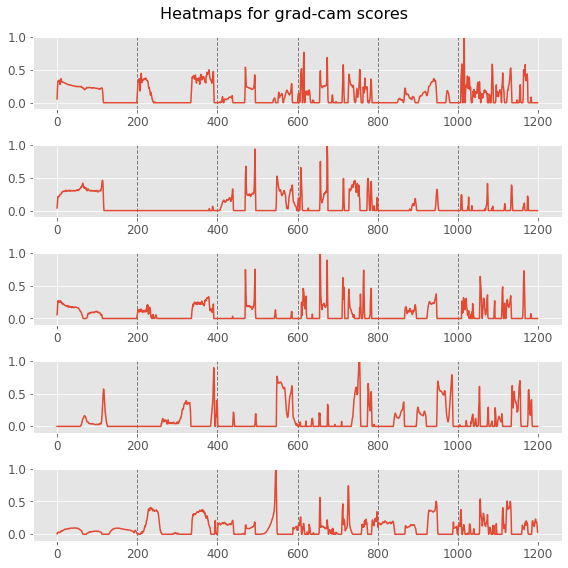

In [68]:
## Visually check the grad-CAM scores
plt.figure(figsize=(8,8))
plt.suptitle('Heatmaps for grad-cam scores')
for i,h in enumerate(heatmaps):
    plt.subplot(5,1,i+1)
    plt.plot(h)
    ## We use vertical lines to separate the various data pre-processing types like we did in sec. 3.1
    plt.vlines(np.arange(200,1200,200), ymin=-0.1, ymax=1.1, color='k',lw=1,ls='--', alpha=0.5)
    plt.ylim(-0.1,1)
plt.tight_layout()
plt.show()

The following scritp allows for us to color the lines of the spectra of the 5 selected samples as a function of its grad score. The higher the grad scores, the more important the feature is for classification purposes. Due to the ordering used for the list of spectra, in the next graphic the order of the spectra is reversed compared to the previous graphic.

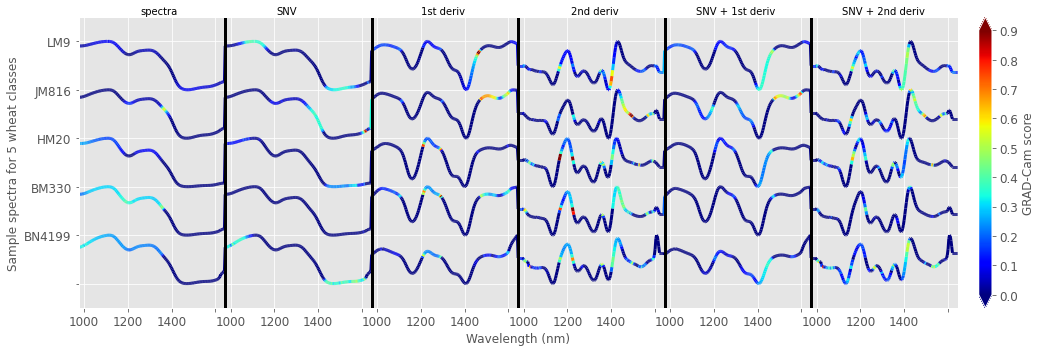

In [69]:
## Plot the original concatenated preprocessed spectra, normalized [0,1] with the color corresponding to their correspondent heatmap (grad-CAM score)

plt.figure(figsize=(16,5)) 
for i in range(5):
    ax=colorline(np.arange(0,4020,3.35),samples_SpecClass[i,:]+i, np.array(heatmaps[i]).T,norm=colors.Normalize(vmin=0.0, vmax=0.9))

## Trick: Each normalized mean sepctra starts around Y=1, therefore we shift the Y labels by 1 to better correspont the name to the curve
wheat_variaties=[' ','BN4199','BM330','HM20', 'JM816','LM9']    

## set custom x-labels
plt.xticks(long_xscale_pos, labels=long_xscale_labels, rotation=0)
plt.yticks(np.arange(6), labels=wheat_variaties, rotation=0)
plt.vlines(np.arange(670,4020,670), ymin=-1, ymax=33, color='k',lw=3)
plt.ylabel('Sample spectra for 5 wheat classes')
plt.xlabel('Wavelength (nm)')
plt.ylim(-0.5,5.5)
plt.xlim(0,4020)
plt.annotate('spectra',(0.070,1.01), xycoords='axes fraction')
plt.annotate('SNV',(0.075*3,1.01), xycoords='axes fraction')
plt.annotate('1st deriv',(0.078*5,1.01), xycoords='axes fraction')
plt.annotate('2nd deriv',(0.08*7,1.01), xycoords='axes fraction')
plt.annotate('SNV + 1st deriv',(0.078*9,1.01), xycoords='axes fraction')
plt.annotate('SNV + 2nd deriv',(0.079*11,1.01), xycoords='axes fraction')
plt.colorbar(ax, extend='both', label='GRAD-Cam score', pad=0.02)
plt.tight_layout()
plt.show()

The manuscript text includes references to additional methods of this kind that can be used to gain insigth about what input data influences the classification process done by the CNN.

The authors encourage the interested user to adapt this code to his/hers own problems and spectral analysis needs and explore the Optuna documentation to take full advantage of the tools it offers.